# Image Classiification on MNIST Dataset using ConvNets(CNN's)

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

This notebook aims at :
1. Building different architectures such as `LeNet` and `LeNet-like`
2. Observing the impact of various Learning rates of the algorithm on both architectures, upon the accuracy of      predictions
3. Analysing the performance of different Optimizers such as `StochasticGD`, `Momentum`, `RMSProp` and `Adam`

The dataset is avialbale here : http://yann.lecun.com/exdb/mnist/

The analysis is done in Python and Tensorflow

The **MNIST** dataset contains 60,000 images of handwritten digits, where each image size is 28 x 28 x 1 (Grayscale) from 0 to 9. The task is to setup a ConvNet to accurately predict the digits in these images. 

Lets import `Numpy` and `Tensorflow`

In [1]:
import tensorflow as tf
import numpy as np

First, lets define some methods which are convenient for loading and reshaping the data into the necessary format.

1. `randomize()` for loading the data in a randomized array

2. `one_hot_encode()`for one-hot encoding the labels

3. `reformat_data` for reformatting as the name suggests

4. `flatten_tf_array` a method for flattening an array (since a fully connected network needs an flat array as its input)

In [2]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

def one_hot_encode(np_array):
    return (np.arange(10) == np_array[:,None]).astype(np.float32)

def reformat_data(dataset, labels, image_width, image_height, image_depth):
    np_dataset_ = np.array([np.array(image_data).reshape(image_width, image_height, image_depth) for image_data in dataset])
    np_labels_ = one_hot_encode(np.array(labels, dtype=np.float32))
    np_dataset, np_labels = randomize(np_dataset_, np_labels_)
    return np_dataset, np_labels

def flatten_tf_array(array):
    shape = array.get_shape().as_list()
    return tf.reshape(array, [shape[0], shape[1] * shape[2] * shape[3]])
    
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

Now define the image parameters

In [3]:
mnist_folder = './data/mnist/'
mnist_image_width = 28
mnist_image_height = 28
mnist_image_depth = 1
mnist_num_labels = 10

Import the MNIST tool and load the **MNIST** dataset after reformatting

In [4]:
from mnist import MNIST
mndata = MNIST(mnist_folder)
mnist_train_dataset_, mnist_train_labels_ = mndata.load_training()
mnist_test_dataset_, mnist_test_labels_ = mndata.load_testing()

In [5]:
mnist_train_dataset, mnist_train_labels = reformat_data(mnist_train_dataset_, mnist_train_labels_, mnist_image_width, mnist_image_height, mnist_image_depth)
mnist_test_dataset, mnist_test_labels = reformat_data(mnist_test_dataset_, mnist_test_labels_, mnist_image_width, mnist_image_height, mnist_image_depth)

In [6]:
print("There are {} images in the training set, each of pixel size {}".format(len(mnist_train_dataset[0]), len(mnist_train_dataset[1])))
print("Meaning each image has the size of 28(width)*28(height)*1(depth) = {}".format(mnist_image_width*mnist_image_height*1))
print("The training set contains the following {} labels: {}".format(len(np.unique(mnist_train_labels_)), np.unique(mnist_train_labels_)))

There are 28 images in the training set, each of pixel size 28
Meaning each image has the size of 28(width)*28(height)*1(depth) = 784
The training set contains the following 10 labels: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
from IPython.display import Image
Image("MNIST.png")

As above there are 60,000 images each of size 28 X 28 with a depth of 1. Lets now create the LeNet 5 Architecture for the dataset

## 1. LeNet5

The LeNet5 CNN architecture was thought of by Yann Lecun as early as in 1998. It is one of the earliest CNN’s  and was specifically designed to classify handwritten digits. Although it performs well on the MNIST dataset which consist of grayscale images of size 28 x 28, the performance drops on other datasets with more images, with a larger resolution (larger image size) and more classes. For these larger datasets, deeper ConvNets (like AlexNet, VGGNet or ResNet), will perform better. Read more here : http://yann.lecun.com/exdb/lenet/

The structure is shown below :

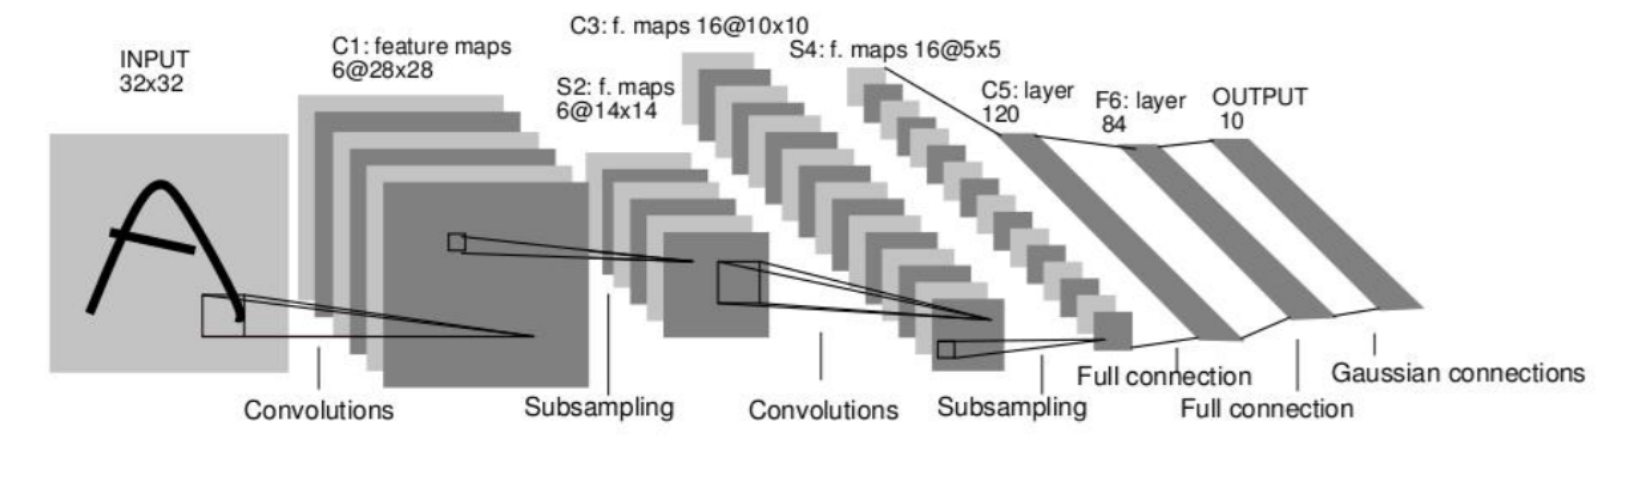

In [7]:
from IPython.display import Image
Image("LeNet5.png")

As we can see, it consists of 5 layers:

layer 1: a convolutional layer, with a sigmoid activation function, followed by an average pooling layer.

layer 2: a convolutional layer, with a sigmoid activation function, followed by an average pooling layer.

layer 3: a fully connected network (sigmoid activation)

layer 4: a fully connected network (sigmoid activation)

layer 5: the output layer

This means that we need to create 5 weight and bias matrices, and our model will consists of 12 lines of code (5 layers + 2 pooling + 4 activation functions + 1 flatten layer).
Since this is quiet some code, it is best to define these in a seperate function outside of the graph.

In [8]:
LENET5_BATCH_SIZE = 32
LENET5_FILTER_SIZE = 5
LENET5_FILTER_DEPTH_1 = 6
LENET5_FILTER_DEPTH_2 = 16
LENET5_NUM_HIDDEN_1 = 120
LENET5_NUM_HIDDEN_2 = 84
 
def variables_lenet5(filter_size = LENET5_FILTER_SIZE, 
                     filter_depth1 = LENET5_FILTER_DEPTH_1, 
                     filter_depth2 = LENET5_FILTER_DEPTH_2, 
                     num_hidden1 = LENET5_NUM_HIDDEN_1, 
                     num_hidden2 = LENET5_NUM_HIDDEN_2,
                     image_depth = 1, 
                     num_labels = 10):
    
    w1 = tf.Variable(tf.truncated_normal([filter_size, filter_size, image_depth, filter_depth1], stddev=0.1))
    b1 = tf.Variable(tf.zeros([filter_depth1]))
 
    w2 = tf.Variable(tf.truncated_normal([filter_size, filter_size, filter_depth1, filter_depth2], stddev=0.1))
    b2 = tf.Variable(tf.constant(1.0, shape=[filter_depth2]))
 
    w3 = tf.Variable(tf.truncated_normal([5*5*filter_depth2, num_hidden1], stddev=0.1))
    b3 = tf.Variable(tf.constant(1.0, shape = [num_hidden1]))
 
    w4 = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1))
    b4 = tf.Variable(tf.constant(1.0, shape = [num_hidden2]))
    
    w5 = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    b5 = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    variables = {
        'w1': w1, 'w2': w2, 'w3': w3, 'w4': w4, 'w5': w5,
        'b1': b1, 'b2': b2, 'b3': b3, 'b4': b4, 'b5': b5
    }
    return variables
 
def model_lenet5(data, variables):
    layer1_conv = tf.nn.conv2d(data, variables['w1'], [1, 1, 1, 1], padding='SAME')
    layer1_actv = tf.sigmoid(layer1_conv + variables['b1'])
    layer1_pool = tf.nn.avg_pool(layer1_actv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
 
    layer2_conv = tf.nn.conv2d(layer1_pool, variables['w2'], [1, 1, 1, 1], padding='VALID')
    layer2_actv = tf.sigmoid(layer2_conv + variables['b2'])
    layer2_pool = tf.nn.avg_pool(layer2_actv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
 
    flat_layer = flatten_tf_array(layer2_pool)
    layer3_fccd = tf.matmul(flat_layer, variables['w3']) + variables['b3']
    layer3_actv = tf.nn.sigmoid(layer3_fccd)
    
    layer4_fccd = tf.matmul(layer3_actv, variables['w4']) + variables['b4']
    layer4_actv = tf.nn.sigmoid(layer4_fccd)
    logits = tf.matmul(layer4_actv, variables['w5']) + variables['b5']
    return logits

Inside the Graph, we load the data, define the weight matrices and the model, calculate the loss value from the logit vector and pass this to the optimizer which will update the weights for ‘num_steps’ number of iterations.

For mini-batch optimization, we are selecting  small batches from the training dataset, and training the convolutional neural network each time with a batch.

The activation function used is `sigmoid` in all the four layers

In [9]:
def run_fn(learning_rate):
    #parameters determining the model size
    image_width = mnist_image_width
    image_height = mnist_image_height
    image_depth = mnist_image_depth
    num_labels = mnist_num_labels 

    #the datasets
    train_dataset = mnist_train_dataset
    train_labels = mnist_train_labels
    test_dataset = mnist_test_dataset
    test_labels = mnist_test_labels

    #number of iterations and learning rate
    num_steps = 10001
    display_step = 1000
    batch_size = 32

    graph = tf.Graph()
    with graph.as_default():
        #1) First we put the input data in a tensorflow friendly form. 
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
        tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset, tf.float32)
 
        #2) Then, the weight matrices and bias vectors are initialized
        variables = variables_lenet5(image_depth = image_depth, num_labels = num_labels)
 
        #3. The model used to calculate the logits (predicted labels)
        model = model_lenet5
        logits = model(tf_train_dataset, variables)
 
        #4. then we compute the softmax cross entropy between the logits and the (actual) labels
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
        #5. The optimizer is used to calculate the gradients of the loss function 
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
 
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset, variables))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized with learning_rate', learning_rate)
        print('Running a Mini-batch Stochastic Gradient Descent optimization')
        for step in range(num_steps):

            # Selecting batches for MiniBatch Optimization
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
        
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
            if step % display_step == 0:
                train_accuracy = accuracy(predictions, batch_labels)
                test_accuracy = accuracy(test_prediction.eval(), test_labels)
                message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} %".format(step, l, train_accuracy, test_accuracy)
                print(message)

## 1.1 Learning Rates on Lenet 5

The network has been structured as above , with a Stochastic GD. Lets try training the LeNet5 with a learning rate of 0.01 and followed by 0.1

In [10]:
run_fn(learning_rate = 0.01)

Initialized with learning_rate 0.01
Running a Mini-batch Stochastic Gradient Descent optimization
step 0000 : loss is 002.40, accuracy on training set 9.38 %, accuracy on test set 11.35 %
step 1000 : loss is 002.33, accuracy on training set 6.25 %, accuracy on test set 10.10 %
step 2000 : loss is 002.29, accuracy on training set 12.50 %, accuracy on test set 10.10 %
step 3000 : loss is 002.30, accuracy on training set 9.38 %, accuracy on test set 11.35 %
step 4000 : loss is 002.31, accuracy on training set 12.50 %, accuracy on test set 9.58 %
step 5000 : loss is 002.29, accuracy on training set 6.25 %, accuracy on test set 9.77 %
step 6000 : loss is 002.30, accuracy on training set 3.12 %, accuracy on test set 20.08 %
step 7000 : loss is 002.30, accuracy on training set 9.38 %, accuracy on test set 11.35 %
step 8000 : loss is 002.30, accuracy on training set 6.25 %, accuracy on test set 9.58 %
step 9000 : loss is 002.28, accuracy on training set 15.62 %, accuracy on test set 9.82 %
ste

In [12]:
run_fn(learning_rate = 0.1)

Initialized with learning_rate 0.1
Running a Mini-batch Stochastic Gradient Descent optimization
step 0000 : loss is 002.48, accuracy on training set 9.38 %, accuracy on test set 10.28 %
step 1000 : loss is 002.39, accuracy on training set 9.38 %, accuracy on test set 10.10 %
step 2000 : loss is 000.61, accuracy on training set 81.25 %, accuracy on test set 75.48 %
step 3000 : loss is 000.36, accuracy on training set 90.62 %, accuracy on test set 90.12 %
step 4000 : loss is 000.16, accuracy on training set 96.88 %, accuracy on test set 92.84 %
step 5000 : loss is 000.07, accuracy on training set 100.00 %, accuracy on test set 94.68 %
step 6000 : loss is 000.19, accuracy on training set 96.88 %, accuracy on test set 95.28 %
step 7000 : loss is 000.46, accuracy on training set 90.62 %, accuracy on test set 95.39 %
step 8000 : loss is 000.22, accuracy on training set 96.88 %, accuracy on test set 96.60 %
step 9000 : loss is 000.06, accuracy on training set 96.88 %, accuracy on test set 96

The accuracy is considerably increased by eight times after 10000 iterations, upon increasing the learning rate by a factor of 10. So lets choose the **learning_rate = 0.1** as an optimal value for LeNet 5

## 1.2 Optimizers on LeNet 5

Now lets see how far the accuracy of predictions vary depending on the type of Optimizer used. We will try:


1. `Momentum`- makes use of exponentially weighted averages of past gradients in the parameter update equations
2. `RMSProp` - makes use of exponentially weighted averages of squares of past gradients in the parameter updates
3. `Adam` - Combining `Momentum` and `Adam`

### 1.2.1 Momentum on Lenet 5

In [13]:
def run_fn(learning_rate):
    #parameters determining the model size
    image_width = mnist_image_width
    image_height = mnist_image_height
    image_depth = mnist_image_depth
    num_labels = mnist_num_labels 

    #the datasets
    train_dataset = mnist_train_dataset
    train_labels = mnist_train_labels
    test_dataset = mnist_test_dataset
    test_labels = mnist_test_labels

    #number of iterations and learning rate
    num_steps = 10001
    display_step = 1000
    batch_size = 32

    graph = tf.Graph()
    with graph.as_default():
        #1) First we put the input data in a tensorflow friendly form. 
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
        tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset, tf.float32)
 
        #2) Then, the weight matrices and bias vectors are initialized
        variables = variables_lenet5(image_depth = image_depth, num_labels = num_labels)
 
        #3. The model used to calculate the logits (predicted labels)
        model = model_lenet5
        logits = model(tf_train_dataset, variables)
 
        #4. then we compute the softmax cross entropy between the logits and the (actual) labels
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
        #5. The optimizer is used to calculate the gradients of the loss function 
        optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9).minimize(loss)
 
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset, variables))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized with learning_rate', learning_rate)
        print('Running mini batch Momentum Optimizer')
        for step in range(num_steps):

            # Selecting batches for Stochastic GD 
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
        
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
            if step % display_step == 0:
                train_accuracy = accuracy(predictions, batch_labels)
                test_accuracy = accuracy(test_prediction.eval(), test_labels)
                message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} %".format(step, l, train_accuracy, test_accuracy)
                print(message)

In [14]:
run_fn(learning_rate = 0.1)

Initialized with learning_rate 0.1
Running mini batch Momentum Optimizer
step 0000 : loss is 002.48, accuracy on training set 9.38 %, accuracy on test set 9.74 %
step 1000 : loss is 002.33, accuracy on training set 6.25 %, accuracy on test set 11.35 %
step 2000 : loss is 000.05, accuracy on training set 100.00 %, accuracy on test set 93.30 %
step 3000 : loss is 000.10, accuracy on training set 96.88 %, accuracy on test set 96.20 %
step 4000 : loss is 000.04, accuracy on training set 100.00 %, accuracy on test set 96.84 %
step 5000 : loss is 000.00, accuracy on training set 100.00 %, accuracy on test set 97.53 %
step 6000 : loss is 000.04, accuracy on training set 100.00 %, accuracy on test set 97.89 %
step 7000 : loss is 000.26, accuracy on training set 96.88 %, accuracy on test set 97.67 %
step 8000 : loss is 000.03, accuracy on training set 96.88 %, accuracy on test set 98.54 %
step 9000 : loss is 000.01, accuracy on training set 100.00 %, accuracy on test set 97.92 %
step 10000 : lo

### 1.2.2 RMSProp on Lenet 5

In [17]:
def run_fn(learning_rate):
    #parameters determining the model size
    image_width = mnist_image_width
    image_height = mnist_image_height
    image_depth = mnist_image_depth
    num_labels = mnist_num_labels 

    #the datasets
    train_dataset = mnist_train_dataset
    train_labels = mnist_train_labels
    test_dataset = mnist_test_dataset
    test_labels = mnist_test_labels

    #number of iterations and learning rate
    num_steps = 10001
    display_step = 1000
    batch_size = 32

    graph = tf.Graph()
    with graph.as_default():
        #1) First we put the input data in a tensorflow friendly form. 
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
        tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset, tf.float32)
 
        #2) Then, the weight matrices and bias vectors are initialized
        variables = variables_lenet5(image_depth = image_depth, num_labels = num_labels)
 
        #3. The model used to calculate the logits (predicted labels)
        model = model_lenet5
        logits = model(tf_train_dataset, variables)
 
        #4. then we compute the softmax cross entropy between the logits and the (actual) labels
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
        #5. The optimizer is used to calculate the gradients of the loss function 
        optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate, decay=0.999, momentum=0.0,
                                              epsilon=1e-8,).minimize(loss)
 
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset, variables))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized with learning_rate', learning_rate)
        print('Running on RMSProp Optimizer')
        for step in range(num_steps):

            # Selecting batches  
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
        
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
            if step % display_step == 0:
                train_accuracy = accuracy(predictions, batch_labels)
                test_accuracy = accuracy(test_prediction.eval(), test_labels)
                message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} %".format(step, l, train_accuracy, test_accuracy)
                print(message)

In [18]:
run_fn(learning_rate = 0.1)

Initialized with learning_rate 0.1
Running on RMSProp Optimizer
step 0000 : loss is 002.49, accuracy on training set 12.50 %, accuracy on test set 10.32 %
step 1000 : loss is 002.17, accuracy on training set 9.38 %, accuracy on test set 30.12 %
step 2000 : loss is 000.14, accuracy on training set 100.00 %, accuracy on test set 90.09 %
step 3000 : loss is 000.23, accuracy on training set 93.75 %, accuracy on test set 93.60 %
step 4000 : loss is 000.05, accuracy on training set 100.00 %, accuracy on test set 96.00 %
step 5000 : loss is 000.01, accuracy on training set 100.00 %, accuracy on test set 96.35 %
step 6000 : loss is 000.13, accuracy on training set 96.88 %, accuracy on test set 95.84 %
step 7000 : loss is 000.22, accuracy on training set 96.88 %, accuracy on test set 96.66 %
step 8000 : loss is 000.06, accuracy on training set 96.88 %, accuracy on test set 96.88 %
step 9000 : loss is 000.21, accuracy on training set 93.75 %, accuracy on test set 92.74 %
step 10000 : loss is 000

### 1.2.3 Adam on Lenet 5

In [19]:
def run_fn(learning_rate):
    #parameters determining the model size
    image_width = mnist_image_width
    image_height = mnist_image_height
    image_depth = mnist_image_depth
    num_labels = mnist_num_labels 

    #the datasets
    train_dataset = mnist_train_dataset
    train_labels = mnist_train_labels
    test_dataset = mnist_test_dataset
    test_labels = mnist_test_labels

    #number of iterations and learning rate
    num_steps = 10001
    display_step = 1000
    batch_size = 32

    graph = tf.Graph()
    with graph.as_default():
        #1) First we put the input data in a tensorflow friendly form. 
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
        tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset, tf.float32)
 
        #2) Then, the weight matrices and bias vectors are initialized
        variables = variables_lenet5(image_depth = image_depth, num_labels = num_labels)
 
        #3. The model used to calculate the logits (predicted labels)
        model = model_lenet5
        logits = model(tf_train_dataset, variables)
 
        #4. then we compute the softmax cross entropy between the logits and the (actual) labels
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
        #5. The optimizer is used to calculate the gradients of the loss function 
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.999,
                                              epsilon=1e-8,).minimize(loss)
 
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset, variables))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized with learning_rate of', learning_rate)
        print('Running on Adam on LeNet 5')
        for step in range(num_steps):

            # Selecting batches for Stochastic GD 
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
        
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
            if step % display_step == 0:
                train_accuracy = accuracy(predictions, batch_labels)
                test_accuracy = accuracy(test_prediction.eval(), test_labels)
                message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} %".format(step, l, train_accuracy, test_accuracy)
                print(message)

In [20]:
run_fn(learning_rate = 0.1)

Initialized with learning_rate of 0.1
Running on Adam on LeNet 5
step 0000 : loss is 002.45, accuracy on training set 15.62 %, accuracy on test set 10.28 %
step 1000 : loss is 002.47, accuracy on training set 6.25 %, accuracy on test set 10.28 %
step 2000 : loss is 002.32, accuracy on training set 6.25 %, accuracy on test set 10.28 %
step 3000 : loss is 002.44, accuracy on training set 9.38 %, accuracy on test set 10.09 %
step 4000 : loss is 003.51, accuracy on training set 6.25 %, accuracy on test set 10.32 %
step 5000 : loss is 002.78, accuracy on training set 15.62 %, accuracy on test set 11.35 %
step 6000 : loss is 002.61, accuracy on training set 3.12 %, accuracy on test set 10.32 %
step 7000 : loss is 002.53, accuracy on training set 18.75 %, accuracy on test set 9.58 %
step 8000 : loss is 002.58, accuracy on training set 6.25 %, accuracy on test set 9.80 %
step 9000 : loss is 002.55, accuracy on training set 12.50 %, accuracy on test set 11.35 %
step 10000 : loss is 002.54, accu

## 2. LeNet5-like

As the name suggests, it is a slight but significant modification to the original LeNet 5. Here we modify the activations in the layers to `relu` and run again with the same strategies in LeNet.

In [21]:
LENET5_LIKE_BATCH_SIZE = 32
LENET5_LIKE_FILTER_SIZE = 5
LENET5_LIKE_FILTER_DEPTH = 16
LENET5_LIKE_NUM_HIDDEN = 120
 
def variables_lenet5_like(filter_size = LENET5_LIKE_FILTER_SIZE, 
                          filter_depth = LENET5_LIKE_FILTER_DEPTH, 
                          num_hidden = LENET5_LIKE_NUM_HIDDEN,
                          image_width = 28, image_depth = 1, num_labels = 10):
 
    w1 = tf.Variable(tf.truncated_normal([filter_size, filter_size, image_depth, filter_depth], stddev=0.1))
    b1 = tf.Variable(tf.zeros([filter_depth]))
 
    w2 = tf.Variable(tf.truncated_normal([filter_size, filter_size, filter_depth, filter_depth], stddev=0.1))
    b2 = tf.Variable(tf.constant(1.0, shape=[filter_depth]))
 
    w3 = tf.Variable(tf.truncated_normal([(image_width // 4)*(image_width // 4)*filter_depth , num_hidden], stddev=0.1))
    b3 = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
 
    w4 = tf.Variable(tf.truncated_normal([num_hidden, num_hidden], stddev=0.1))
    b4 = tf.Variable(tf.constant(1.0, shape = [num_hidden]))
 
    w5 = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    b5 = tf.Variable(tf.constant(1.0, shape = [num_labels]))
    variables = {
                  'w1': w1, 'w2': w2, 'w3': w3, 'w4': w4, 'w5': w5,
                  'b1': b1, 'b2': b2, 'b3': b3, 'b4': b4, 'b5': b5
                }
    return variables
 
def model_lenet5_like(data, variables):
    layer1_conv = tf.nn.conv2d(data, variables['w1'], [1, 1, 1, 1], padding='SAME')
    layer1_actv = tf.nn.relu(layer1_conv + variables['b1'])
    layer1_pool = tf.nn.avg_pool(layer1_actv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
 
    layer2_conv = tf.nn.conv2d(layer1_pool, variables['w2'], [1, 1, 1, 1], padding='SAME')
    layer2_actv = tf.nn.relu(layer2_conv + variables['b2'])
    layer2_pool = tf.nn.avg_pool(layer2_actv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
 
    flat_layer = flatten_tf_array(layer2_pool)
    layer3_fccd = tf.matmul(flat_layer, variables['w3']) + variables['b3']
    layer3_actv = tf.nn.relu(layer3_fccd)
    
 
    layer4_fccd = tf.matmul(layer3_actv, variables['w4']) + variables['b4']
    layer4_actv = tf.nn.relu(layer4_fccd)
   
 
    logits = tf.matmul(layer4_actv, variables['w5']) + variables['b5']
    return logits

In [24]:
def run_fn(learning_rate):
    #parameters determining the model size
    image_width = mnist_image_width
    image_height = mnist_image_height
    image_depth = mnist_image_depth
    num_labels = mnist_num_labels 

    #the datasets
    train_dataset = mnist_train_dataset
    train_labels = mnist_train_labels
    test_dataset = mnist_test_dataset
    test_labels = mnist_test_labels

    #number of iterations and learning rate
    num_steps = 10001
    display_step = 1000
    batch_size = 32

    graph = tf.Graph()
    with graph.as_default():
        #1) First we put the input data in a tensorflow friendly form. 
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
        tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset, tf.float32)
 
        #2) Then, the weight matrices and bias vectors are initialized
        variables = variables_lenet5(image_depth = image_depth, num_labels = num_labels)
 
        #3. The model used to calculate the logits (predicted labels)
        model = model_lenet5
        logits = model(tf_train_dataset, variables)
 
        #4. then we compute the softmax cross entropy between the logits and the (actual) labels
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
        #5. The optimizer is used to calculate the gradients of the loss function 
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
 
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset, variables))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized with learning_rate', learning_rate)
        for step in range(num_steps):

            # Selecting mini batches
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
        
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
            if step % display_step == 0:
                train_accuracy = accuracy(predictions, batch_labels)
                test_accuracy = accuracy(test_prediction.eval(), test_labels)
                message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} %".format(step, l, train_accuracy, test_accuracy)
                print(message)

### 2.1 Learning Rates

Lets try LeNet 5-like  with two learning rates

In [25]:
run_fn(learning_rate = 0.01)

Initialized with learning_rate 0.01
step 0000 : loss is 002.37, accuracy on training set 12.50 %, accuracy on test set 10.28 %
step 1000 : loss is 002.33, accuracy on training set 6.25 %, accuracy on test set 10.10 %
step 2000 : loss is 002.29, accuracy on training set 12.50 %, accuracy on test set 10.10 %
step 3000 : loss is 002.30, accuracy on training set 9.38 %, accuracy on test set 11.35 %
step 4000 : loss is 002.30, accuracy on training set 12.50 %, accuracy on test set 9.58 %
step 5000 : loss is 002.29, accuracy on training set 6.25 %, accuracy on test set 16.80 %
step 6000 : loss is 002.30, accuracy on training set 3.12 %, accuracy on test set 20.70 %
step 7000 : loss is 002.29, accuracy on training set 9.38 %, accuracy on test set 11.35 %
step 8000 : loss is 002.28, accuracy on training set 6.25 %, accuracy on test set 18.38 %
step 9000 : loss is 002.25, accuracy on training set 21.88 %, accuracy on test set 13.81 %
step 10000 : loss is 002.24, accuracy on training set 28.12 %

In [26]:
run_fn(learning_rate = 0.1)

Initialized with learning_rate 0.1
step 0000 : loss is 002.51, accuracy on training set 9.38 %, accuracy on test set 9.82 %
step 1000 : loss is 002.39, accuracy on training set 9.38 %, accuracy on test set 10.10 %
step 2000 : loss is 000.64, accuracy on training set 87.50 %, accuracy on test set 74.64 %
step 3000 : loss is 000.35, accuracy on training set 87.50 %, accuracy on test set 89.75 %
step 4000 : loss is 000.18, accuracy on training set 93.75 %, accuracy on test set 92.65 %
step 5000 : loss is 000.09, accuracy on training set 100.00 %, accuracy on test set 94.27 %
step 6000 : loss is 000.17, accuracy on training set 93.75 %, accuracy on test set 94.87 %
step 7000 : loss is 000.45, accuracy on training set 93.75 %, accuracy on test set 95.39 %
step 8000 : loss is 000.18, accuracy on training set 96.88 %, accuracy on test set 95.91 %
step 9000 : loss is 000.09, accuracy on training set 96.88 %, accuracy on test set 96.30 %
step 10000 : loss is 000.06, accuracy on training set 100

### 2.2 Optimizers

Now lets see how far the accuracy of predictions vary depending on the type of Optimizer used with LeNet 5 -like. We will try:

1. `Momentum`- makes use of exponentially weighted averages of past gradients in the parameter update equations
2. `RMSProp` - makes use of exponentially weighted averages of squares of past gradients in the parameter updates
3. `Adam` - Combining `Momentum` and `Adam`

### 2.2.1 Momentum on Lenet5_like

In [27]:
def run_fn(learning_rate):
    #parameters determining the model size
    image_width = mnist_image_width
    image_height = mnist_image_height
    image_depth = mnist_image_depth
    num_labels = mnist_num_labels 

    #the datasets
    train_dataset = mnist_train_dataset
    train_labels = mnist_train_labels
    test_dataset = mnist_test_dataset
    test_labels = mnist_test_labels

    #number of iterations and learning rate
    num_steps = 10001
    display_step = 1000
    batch_size = 32

    graph = tf.Graph()
    with graph.as_default():
        #1) First we put the input data in a tensorflow friendly form. 
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
        tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset, tf.float32)
 
        #2) Then, the weight matrices and bias vectors are initialized
        variables = variables_lenet5(image_depth = image_depth, num_labels = num_labels)
 
        #3. The model used to calculate the logits (predicted labels)
        model = model_lenet5
        logits = model(tf_train_dataset, variables)
 
        #4. then we compute the softmax cross entropy between the logits and the (actual) labels
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
        #5. The optimizer is used to calculate the gradients of the loss function 
        optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9).minimize(loss)
 
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset, variables))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized with learning_rate', learning_rate)
        print('Running on Momentum Optimizer')
        for step in range(num_steps):

            # Selecting mini batches 
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
        
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
            if step % display_step == 0:
                train_accuracy = accuracy(predictions, batch_labels)
                test_accuracy = accuracy(test_prediction.eval(), test_labels)
                message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} %".format(step, l, train_accuracy, test_accuracy)
                print(message)

In [28]:
run_fn(learning_rate = 0.1)

Initialized with learning_rate 0.1
Running on Momentum Optimizer
step 0000 : loss is 002.35, accuracy on training set 12.50 %, accuracy on test set 9.74 %
step 1000 : loss is 000.73, accuracy on training set 78.12 %, accuracy on test set 83.85 %
step 2000 : loss is 000.04, accuracy on training set 100.00 %, accuracy on test set 94.51 %
step 3000 : loss is 000.04, accuracy on training set 100.00 %, accuracy on test set 97.01 %
step 4000 : loss is 000.10, accuracy on training set 93.75 %, accuracy on test set 97.21 %
step 5000 : loss is 000.01, accuracy on training set 100.00 %, accuracy on test set 97.38 %
step 6000 : loss is 000.05, accuracy on training set 96.88 %, accuracy on test set 98.17 %
step 7000 : loss is 000.27, accuracy on training set 96.88 %, accuracy on test set 98.02 %
step 8000 : loss is 000.01, accuracy on training set 100.00 %, accuracy on test set 98.52 %
step 9000 : loss is 000.08, accuracy on training set 96.88 %, accuracy on test set 98.07 %
step 10000 : loss is 0

### 2.2.2RMSProp on Lenet5_like

In [29]:
def run_fn(learning_rate):
    #parameters determining the model size
    image_width = mnist_image_width
    image_height = mnist_image_height
    image_depth = mnist_image_depth
    num_labels = mnist_num_labels 

    #the datasets
    train_dataset = mnist_train_dataset
    train_labels = mnist_train_labels
    test_dataset = mnist_test_dataset
    test_labels = mnist_test_labels

    #number of iterations and learning rate
    num_steps = 10001
    display_step = 1000
    batch_size = 32

    graph = tf.Graph()
    with graph.as_default():
        #1) First we put the input data in a tensorflow friendly form. 
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
        tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset, tf.float32)
 
        #2) Then, the weight matrices and bias vectors are initialized
        variables = variables_lenet5(image_depth = image_depth, num_labels = num_labels)
 
        #3. The model used to calculate the logits (predicted labels)
        model = model_lenet5
        logits = model(tf_train_dataset, variables)
 
        #4. then we compute the softmax cross entropy between the logits and the (actual) labels
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
        #5. The optimizer is used to calculate the gradients of the loss function 
        optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate, decay=0.999, momentum=0.0,
                                              epsilon=1e-8,).minimize(loss)
 
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset, variables))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized with learning_rate', learning_rate)
        print('Running on RMSProp Optimizer')
        for step in range(num_steps):

            # Selecting batches  
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
        
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
            if step % display_step == 0:
                train_accuracy = accuracy(predictions, batch_labels)
                test_accuracy = accuracy(test_prediction.eval(), test_labels)
                message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} %".format(step, l, train_accuracy, test_accuracy)
                print(message)

In [30]:
run_fn(learning_rate = 0.1)

Initialized with learning_rate 0.1
Running on RMSProp Optimizer
step 0000 : loss is 002.76, accuracy on training set 6.25 %, accuracy on test set 11.35 %
step 1000 : loss is 002.31, accuracy on training set 15.62 %, accuracy on test set 29.22 %
step 2000 : loss is 000.20, accuracy on training set 96.88 %, accuracy on test set 91.18 %
step 3000 : loss is 000.20, accuracy on training set 93.75 %, accuracy on test set 94.03 %
step 4000 : loss is 000.13, accuracy on training set 96.88 %, accuracy on test set 96.57 %
step 5000 : loss is 000.01, accuracy on training set 100.00 %, accuracy on test set 96.66 %
step 6000 : loss is 000.13, accuracy on training set 96.88 %, accuracy on test set 96.38 %
step 7000 : loss is 000.27, accuracy on training set 93.75 %, accuracy on test set 96.75 %
step 8000 : loss is 000.15, accuracy on training set 96.88 %, accuracy on test set 96.47 %
step 9000 : loss is 000.05, accuracy on training set 96.88 %, accuracy on test set 96.28 %
step 10000 : loss is 000.0

### 2.2.3 Adam on Lenet5_like

In [31]:
def run_fn(learning_rate):
    #parameters determining the model size
    image_width = mnist_image_width
    image_height = mnist_image_height
    image_depth = mnist_image_depth
    num_labels = mnist_num_labels 

    #the datasets
    train_dataset = mnist_train_dataset
    train_labels = mnist_train_labels
    test_dataset = mnist_test_dataset
    test_labels = mnist_test_labels

    #number of iterations and learning rate
    num_steps = 10001
    display_step = 1000
    batch_size = 32

    graph = tf.Graph()
    with graph.as_default():
        #1) First we put the input data in a tensorflow friendly form. 
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
        tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
        tf_test_dataset = tf.constant(test_dataset, tf.float32)
 
        #2) Then, the weight matrices and bias vectors are initialized
        variables = variables_lenet5(image_depth = image_depth, num_labels = num_labels)
 
        #3. The model used to calculate the logits (predicted labels)
        model = model_lenet5
        logits = model(tf_train_dataset, variables)
 
        #4. then we compute the softmax cross entropy between the logits and the (actual) labels
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    
        #5. The optimizer is used to calculate the gradients of the loss function 
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.999,
                                              epsilon=1e-8,).minimize(loss)
 
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        test_prediction = tf.nn.softmax(model(tf_test_dataset, variables))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized with learning_rate', learning_rate)
        print('Running on Adam Optimizer')
        for step in range(num_steps):

            # Selecting batches for Stochastic GD 
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
        
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
            if step % display_step == 0:
                train_accuracy = accuracy(predictions, batch_labels)
                test_accuracy = accuracy(test_prediction.eval(), test_labels)
                message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} %".format(step, l, train_accuracy, test_accuracy)
                print(message)

In [32]:
run_fn(learning_rate = 0.1)

Initialized with learning_rate 0.1
Running on Adam Optimizer
step 0000 : loss is 002.40, accuracy on training set 12.50 %, accuracy on test set 9.74 %
step 1000 : loss is 002.44, accuracy on training set 6.25 %, accuracy on test set 10.28 %
step 2000 : loss is 002.35, accuracy on training set 6.25 %, accuracy on test set 10.28 %
step 3000 : loss is 002.47, accuracy on training set 9.38 %, accuracy on test set 10.09 %
step 4000 : loss is 003.34, accuracy on training set 6.25 %, accuracy on test set 10.32 %
step 5000 : loss is 002.74, accuracy on training set 15.62 %, accuracy on test set 11.35 %
step 6000 : loss is 002.58, accuracy on training set 3.12 %, accuracy on test set 10.10 %
step 7000 : loss is 002.56, accuracy on training set 6.25 %, accuracy on test set 8.92 %
step 8000 : loss is 002.56, accuracy on training set 6.25 %, accuracy on test set 9.80 %
step 9000 : loss is 002.53, accuracy on training set 12.50 %, accuracy on test set 11.35 %
step 10000 : loss is 002.59, accuracy o

## Concluding Remarks

1. The LeNet 5 with  sigmoid activations and LeNet 5-like with relu activations networks are developed for the *MNIST* dataset for image recognitions
2. The Learning rate of 0.1 gives out the best prediction accuracies for LeNet 5 compared to 0.01 value. This can even be confirmed by Hyperparamter tuning. The same is the case with LeNet 5 like.
3. Among the optimizers, `Momentum` seems to be the good choice for both the networks. Gradient Descent works well in both cases where as `Adam` does not produce promising results in both architectures.